In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import joblib

train = pd.read_csv('../data/processed/train/train-dengue.csv')
test = pd.read_csv('../data/processed/test/test-dengue.csv')

In [2]:
# Preprocesar datos (dummy variables para categorías)
df_train = pd.get_dummies(train, columns=['SEXO', 'TIPO_PACIENTE', 'RESULTADO_PCR'], drop_first=True)

# Separar características y etiqueta
X_train = df_train.drop('ESTATUS_CASO', axis=1)
y_train = df_train['ESTATUS_CASO']

# Normalizar datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Convertir nombres de columnas a string
X_train_df = pd.DataFrame(X_train, columns=[str(i) for i in range(X_train.shape[1])])
X_train_df['ESTATUS_CASO'] = y_train.values

# Guardar los datos preprocesados
X_train_df.to_parquet('processed_train_data.parquet')
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [3]:
# Construir y evaluar el modelo
model = LogisticRegression(max_iter=1000)

# K-Fold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')

print(f"Cross-validation accuracy scores: {cv_results}")
print(f"Mean cross-validation accuracy: {cv_results.mean()}")

# Entrenar el modelo en todo el conjunto de entrenamiento
model.fit(X_train, y_train)

Cross-validation accuracy scores: [0.65942843 0.66566829 0.65768127 0.65676485 0.66337993]
Mean cross-validation accuracy: 0.6605845537197761


LogisticRegression(max_iter=1000)

In [4]:
# Preprocesar datos de prueba
df_test = pd.get_dummies(test, columns=['SEXO', 'TIPO_PACIENTE', 'RESULTADO_PCR'], drop_first=True)
X_test = df_test.drop('ESTATUS_CASO', axis=1)
y_test = df_test['ESTATUS_CASO']

# Normalizar datos
X_test = scaler.transform(X_test)

In [5]:
# Modelo de regresión logística
model = LogisticRegression(max_iter=1000)

# Ajuste de hiperparámetros
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}  # Ejemplo de valores para ajustar
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Predicción en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.6583466453674122
Classification Report:
              precision    recall  f1-score   support

           1       0.66      0.93      0.78      5632
           2       0.71      0.52      0.60      2016
           3       0.47      0.13      0.21      2368

    accuracy                           0.66     10016
   macro avg       0.62      0.53      0.53     10016
weighted avg       0.63      0.66      0.60     10016



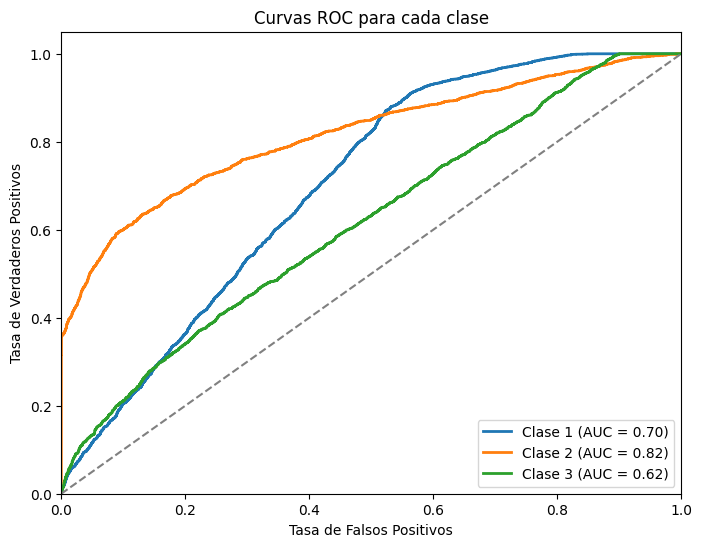

In [17]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from matplotlib import pyplot as plt
import numpy as np

# Obtener las clases únicas de y_test
classes = np.unique(y_test)

# Calcular probabilidades de clase para el conjunto de prueba
y_prob = best_model.predict_proba(X_test)

# Extraer solo las probabilidades positivas
y_prob_positive = y_prob[:, 1]

# Binarizar las etiquetas de clase
y_test_bin = label_binarize(y_test, classes=classes)

# Calcular la curva ROC y el área bajo la curva para cada clase
fpr = dict()                            # Tasa de falsos positivos
tpr = dict()                            # Tasa de verdaderos positivos
roc_auc = dict()                        # Área bajo la curva ROC
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])   # Calcular la curva ROC
    roc_auc[i] = auc(fpr[i], tpr[i])                                # Calcular el área bajo la curva ROC

# Graficar las curvas ROC para cada clase
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label='Clase %d (AUC = %0.2f)' % (i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para cada clase')
plt.legend(loc="lower right")
plt.show()

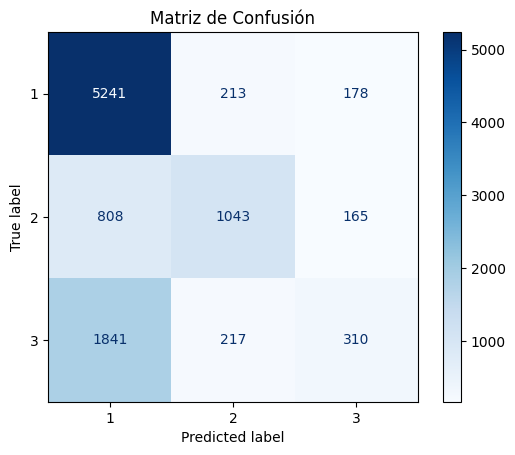

In [18]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred, labels=classes)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

## Propuestas de Mejora

Analizando los resultados obtenidos con las métricas previamente establecidas, podemos ver que hay varios factores que se deben tomar en cuenta y optimizarlos.

1. **Tipo de Modelo**: Estamos usando un modelo simple de regresión logística. Podríamos explorar modelos más complejos como Random Forest, Gradient Boosting o redes neuronales.
   
2. **Desbalance de Clases**: El desbalance de clases es un problema significativo. Podríamos implementar técnicas para manejar este desbalance,como el uso de pesos de clase en los algoritmos de aprendizaje.

3. **Más Datos**: Aumentar la cantidad de datos de entrenamiento puede mejorar significativamente el rendimiento del modelo. Sin embargo, hay que procurar que el aumento de datos sea proporcional al de las clases para evitar nuevamente un desbalance.

4. **Selección de Características**: Podríamos realizar una selección de características más rigurosa para eliminar las características irrelevantes y reducir la dimensionalidad del problema. Aunque hicimos una eliminación previa de características, siempre podemos tratar la problemática con el experto, eliminando caraterísticas y ayudando a que el modelo generalice mejor.

## Conclusión

En conclusión, aunque el modelo de regresión logística nos proporciona una base inicial para la detección del dengue, hay muchas áreas de mejora. La implementación de técnicas avanzadas y el manejo adecuado del desbalance de clases son cruciales para desarrollar un modelo más robusto y preciso. Con más datos y un preprocesamiento más detallado, podemos optimizar nuestro modelo y obtener mejores resultados en la detección temprana del dengue.

En cuanto a las métricas obtenidas, nuestra prioridad era la curva ROC, la cual nos permitió evaluar el rendimiento del modelo en términos de sensibilidad y especificidad para diferentes umbrales de decisión. Observamos que para las etiquetas 1 (Probable) y 2 (Confirmado), el modelo tiene un buen rendimiento. Sin embargo, para la etiqueta 3 (Descartado), el rendimiento es notablemente inferior.

Luego, analizando el recall, que en este contexto es crucial dado que evalúa la efectividad del modelo para identificar correctamente los casos positivos de dengue entre todos los casos que realmente lo son, observamos que el modelo es muy bueno para identificar los casos probables. Sin embargo, para los casos confirmados y descartados, el rendimiento es menos satisfactorio. Esto implica que algunos pacientes que realmente tienen dengue confirmado podrían no ser identificados con la urgencia necesaria, mientras que otros pacientes que no tienen dengue podrían recibir un tratamiento innecesario.

Finalmente, el accuracy del modelo fue del 0.658, lo que indica que poco más de la mitad de las predicciones son correctas. Sin embargo, debido al desbalance de clases, este valor puede ser engañoso. Un accuracy alto en un conjunto de datos desbalanceado puede reflejar un sesgo hacia la clase mayoritaria, en lugar de un buen rendimiento general del modelo.

En resumen, aunque hemos establecido una base sólida con el modelo de regresión logística, es evidente que se necesita un enfoque más sofisticado y un tratamiento cuidadoso del desbalance de clases para mejorar la precisión y efectividad en la detección temprana del dengue.